In [ ]:
!pip install cvzone

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=55691bc5e774db5b1c04ac808abbb8451e476369d5f9ee902d448b2b132e5bed
  Stored in directory: /root/.cache/pip/wheels/ab/36/ec/47be2d4e59dc4289e684d5b0dde54d1e72e51a614e57690e85
Successfully built cvzone


In [ ]:
import json
import cvzone
import cv2
import os
import uuid

import random

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np, torch

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp "/content/drive/MyDrive/Colab Notebooks/scarecrow_dataset.zip" .

#3) Unzip quietly into a folder called `scarecrow_dataset`
#!unzip -q scarecrow_dataset.zip -d scarecrow_dataset

replace scarecrow_dataset/scarecrow_dataset/test/annotations.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# before you run any DataLoaders, adjust this:

# the “real” root is the second folder
dataset_base_dir = '/content/drive/MyDrive/DL2025/scarecrow_dataset/scarecrow_dataset'

train_img_dir    = os.path.join(dataset_base_dir, 'train',       'images')
train_label_path = os.path.join(dataset_base_dir, 'train',       'annotations.json')

val_img_dir      = os.path.join(dataset_base_dir, 'val',         'images')
val_label_path   = os.path.join(dataset_base_dir, 'val',         'annotations.json')

test_img_dir     = os.path.join(dataset_base_dir, 'test',        'images')
test_label_path  = os.path.join(dataset_base_dir, 'test',        'annotations.json')

# Path for saving weights
weights_save_path = 'rf_detr_weights.pth'




In [ ]:
with open('/content/drive/MyDrive/DL2025/scarecrow_dataset/scarecrow_dataset/train/annotations.json', 'r') as f:
     data = json.load(f)

with open(train_label_path, 'r') as f:
    data = json.load(f)

print(data[0].keys())


dict_keys(['NormalizedName', 'OriginalFileName', 'AnnotationData'])


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, label_path, im_path, transforms=None): #to initialize dataset
        with open(label_path, 'r') as file:
            self.data = json.load(file)
        self.im_path = im_path
        self.transforms = transforms
        self.items = self.data


    def __len__(self): #returns number of images
        return len(self.items)


    def __getitem__(self, idx): #returns certain sample
        item = self.items[idx]
        im_path = os.path.join(self.im_path, item['OriginalFileName'])

        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bboxes = []
        labels = []

        for annotation in item.get('AnnotationData', []):
            coords = annotation['Coordinates']
            x_min = int(min(pt['X'] for pt in coords))
            y_min = int(min(pt['Y'] for pt in coords))
            x_max = int(max(pt['X'] for pt in coords))
            y_max = int(max(pt['Y'] for pt in coords))
            bboxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)  # bird class


        #applying transforms
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=bboxes, class_labels=labels)
            image = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['class_labels']

        # Ensure output format is correct, even if empty
        target = {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        return image, target

In [ ]:
import json
from pprint import pprint

with open('/content/drive/MyDrive/DL2025/scarecrow_dataset/scarecrow_dataset/train/annotations.json') as f:
    data = json.load(f)

# 1) print just the top‐level keys
print("Top‐level keys:", data[0].keys())

# 2) pretty‐print the first annotation (limit depth so it’s not too huge)
pprint(data[0], depth=2)


Top‐level keys: dict_keys(['NormalizedName', 'OriginalFileName', 'AnnotationData'])
{'AnnotationData': [{...}, {...}, {...}, {...}, {...}],
 'NormalizedName': 'e961d640-bcfa-49dc-b09a-5e822de5674f',
 'OriginalFileName': 'Schermafbeelding 2024-06-04 105530.png'}


In [ ]:
import json
from pprint import pprint

with open('/content/drive/MyDrive/DL2025/scarecrow_dataset/scarecrow_dataset/train/annotations.json') as f:
    data = json.load(f)

# show the keys in the first annotation
print("AnnotationData[0] keys:", data[0]['AnnotationData'][0].keys())

# pretty-print the full first annotation
pprint(data[0]['AnnotationData'][0])


AnnotationData[0] keys: dict_keys(['Label', 'Coordinates'])
{'Coordinates': [{'X': 730.03857421875, 'Y': 208.64540100097656},
                 {'X': 743.8567504882812, 'Y': 208.64540100097656},
                 {'X': 743.8567504882812, 'Y': 220.64540100097656},
                 {'X': 730.03857421875, 'Y': 220.64540100097656}],
 'Label': 'Bird'}


In [ ]:
transform = A.Compose([
    A.Resize(560, 560),   # 560 to be compatible with rf-detr
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std =(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


In [ ]:
dataset = CustomDataset(
    #label_path='/content/drive/MyDrive/Colab Notebooks/DL2025/scarecrow_dataset/scarecrow_dataset/train/annotations.json',
    #im_path='/content/drive/MyDrive/Colab Notebooks/DL2025/scarecrow_dataset/scarecrow_dataset/train/images',
    #transforms =transform,
    label_path=train_label_path,
    im_path=train_img_dir,
    transforms=transform
)

image, target = dataset[0]
print(f"Image shape: {image.shape}")
print(f"Boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")

Image shape: torch.Size([3, 560, 560])
Boxes: tensor([[343.2917, 107.8519, 347.0833, 114.0741],
        [331.6250, 106.2963, 333.6667, 112.0000],
        [336.5833, 105.2593, 339.5000, 111.4815],
        [295.1667,  96.4445, 297.5000, 101.1111],
        [303.6250, 105.2593, 305.9583, 110.4444]])
Labels: tensor([1, 1, 1, 1, 1])


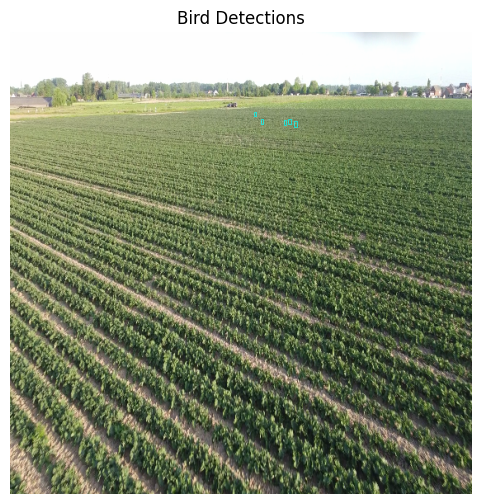

In [ ]:
# Convert image tensor to NumPy and unnormalize (undo normalization)
img = image.permute(1, 2, 0).numpy()  # [3, 512, 512] → [512, 512, 3]
img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
img = img.clip(0, 1)  # Keep values between 0 and 1 for display

# Plot image
plt.figure(figsize=(8, 6))
plt.imshow(img)

# Add bounding boxes
for box in target['boxes']:
    x_min, y_min, x_max, y_max = box.tolist()  # Convert to Python float
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height,
                             linewidth=0.5, edgecolor='cyan', facecolor='none')
    plt.gca().add_patch(rect)

plt.title("Bird Detections")
plt.axis('off')
plt.show()

In [ ]:
def split(batch):
    return tuple(zip(*batch))

dataloader = DataLoader(
    dataset,
    batch_size=4,          # 4 images per batch
    shuffle=True,
    num_workers=0,
    collate_fn = split
)

In [ ]:
images, targets = next(iter(dataloader))

print(f"Batch size: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Boxes in first image: {targets[0]['boxes']}")

Batch size: 4
Image shape: torch.Size([3, 560, 560])
Boxes in first image: tensor([[315.8333, 177.5926, 319.0278, 181.8519],
        [268.1945, 172.5926, 270.5556, 175.7407],
        [375.5556, 176.8518, 378.0555, 180.3704]])


CustomDataset reads each image, applies the Albumentations augmentations, and returns an image tensor plus its bounding-box labels; we wrap it in two DataLoaders so training code can stream the data in mini-batches.
The small split function is a custom collate routine that keeps variable-length target dictionaries intact, which object-detection models (like RF-DETR) require.

In [ ]:
# helper function
# separate the list of tuples into 2 tuples (images, targets)
def split(batch):
    return tuple(zip(*batch))

#make train and val datasets
train_dataset = CustomDataset(
    # label_path='/content/drive/MyDrive/Colab Notebooks/DL2025/scarecrow_dataset/scarecrow_dataset/train/annotations.json',
    # im_path    ='/content/drive/MyDrive/Colab Notebooks/DL2025/scarecrow_dataset/scarecrow_dataset/train/images',
    label_path=train_label_path,
    im_path=train_img_dir,
    transforms =transform
)

val_dataset = CustomDataset(
    # label_path='/content/drive/MyDrive/Colab Notebooks/DL2025/scarecrow_dataset/scarecrow_dataset/val/annotations.json',
    # im_path    ='/content/drive/MyDrive/Colab Notebooks/DL2025/scarecrow_dataset/scarecrow_dataset/val/images',
    label_path=val_label_path,
    im_path=val_img_dir,
    transforms =transform
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle    = True,
    num_workers= 2,
    collate_fn = split
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle    = False,
    num_workers= 2,
    collate_fn = split
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Train batches: 66
Validation batches: 8


In [ ]:
!pip install -q rfdetr supervision

Load a small DINO-v2-based detector (single “bird” class), then loop for two epochs: each batch is sent through the network (core_net(imgs)) (forward pass), the built-in DETR loss (criterion) is summed (compute DETR loss), and AdamW updates the weights.
After every epoch we also run the same loop in eval() mode to get a validation loss, and finally we save the fine-tuned weights to Drive so the inference notebook can load them.

In [ ]:
# import torch
# from rfdetr.detr import RFDETRBase
# from tqdm import tqdm


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # rf detr model
# model = RFDETRBase(
#     encoder="dinov2_windowed_small",
#     num_classes=1,          # 1 class, bird
#     pretrain_weights=None,
#     resolution=560,
#     device=device.type,
#     multi_scale=True,
#     num_queries=500
# )


# core_net  = model.model.model.to(device)  # neural network with weights
# criterion = model.model.criterion    # loss dictionary

# #optimizer and scheduler

# optimizer = torch.optim.AdamW(core_net.parameters(), lr=1e-5, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=2, eta_min=1e-6
# )

# # training and validation
# epochs = 20

# # learning rate scheduler, 3 epoch linear warmup
# warmup_epochs = 3
# warmup_sched = torch.optim.lr_scheduler.LinearLR(
#     optimizer,
#     start_factor=1e-2,
#     total_iters=warmup_epochs
# )
# cosine_sched = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=epochs - warmup_epochs,
#     eta_min=1e-6
# )
# scheduler = torch.optim.lr_scheduler.SequentialLR(
#     optimizer,
#     schedulers=[warmup_sched, cosine_sched],
#     milestones=[warmup_epochs]
# )

# # training
# for epoch in range(epochs):
#     core_net.train()
#     running_loss = 0.0

#     for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [train]"):
#         imgs = torch.stack(imgs).to(device)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         outputs   = core_net(imgs)
#         loss_dict = criterion(outputs, targets)
#         loss      = sum(loss_dict.values())

#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(core_net.parameters(), max_norm=0.1)
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch {epoch+1}  train-loss: {running_loss/len(train_loader):.4f}")

#     scheduler.step()

#     # validation
#     core_net.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for imgs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [val]"):
#             imgs = torch.stack(imgs).to(device)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             outputs   = core_net(imgs)            # forward
#             loss_dict = criterion(outputs, targets)
#             val_loss += sum(loss_dict.values()).item()

#     print(f"Epoch {epoch+1}  val-loss  : {val_loss/len(val_loader):.4f}")

# # save weights
# # torch.save(core_net.state_dict(),
# #            '/content/drive/MyDrive/Colab Notebooks/DL2025/rf_detr_weights.pth')
# torch.save(core_net.state_dict(), weights_save_path)
# print("Weights saved.")



In [ ]:
# import optuna
# import torch
# from torch.utils.data import DataLoader
# from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
# from rfdetr.detr import RFDETRBase
# from tqdm import tqdm

# # assume train_loader & val_loader already defined and use batch_size from trial

# def objective(trial):
#     # ───── 1) sample hyperparameters ─────
#     lr            = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)
#     weight_decay  = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
#     drop_path     = trial.suggest_uniform("drop_path_rate", 0.0, 0.2)
#     num_queries   = trial.suggest_int("num_queries", 100, 600, step=100)
#     resolution    = trial.suggest_categorical("resolution", [392, 560, 800])
#     batch_size    = 4

#     # ───── 2) rebuild dataloaders with new batch_size ─────
#     train_loader.batch_size = batch_size
#     val_loader.batch_size   = batch_size

#     # ───── 3) instantiate model ─────
#     device = torch.device("cuda")
#     model = RFDETRBase(
#         encoder="dinov2_windowed_small",
#         num_classes=1,
#         pretrain_weights=None,
#         resolution=resolution,
#         device=device.type,
#         drop_path_rate=drop_path,
#         num_queries=num_queries,
#         multi_scale=True
#     )
#     core     = model.model.model.to(device)
#     criterion= model.model.criterion

#     # ───── 4) optimizer & 2-stage scheduler ─────
#     optimizer = torch.optim.AdamW(core.parameters(), lr=lr, weight_decay=weight_decay)
#     warmup_epochs = 2
#     total_epochs  = 30
#     warmup_sched = LinearLR(optimizer, start_factor=1e-2, total_iters=warmup_epochs)
#     cosine_sched = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs, eta_min=1e-6)
#     scheduler    = SequentialLR(optimizer, [warmup_sched, cosine_sched], milestones=[warmup_epochs])

#     # ───── 5) train loop (10 epochs) ─────
#     for epoch in range(total_epochs):
#         core.train()
#         for imgs, targets in tqdm(train_loader, desc=f"[train] E{epoch+1}/{total_epochs}"):
#             imgs    = torch.stack(imgs).to(device)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             outs    = core(imgs)
#             ldict   = criterion(outs, targets)
#             loss    = sum(ldict.values())
#             optimizer.zero_grad(); loss.backward()
#             torch.nn.utils.clip_grad_norm_(core.parameters(), 0.1)
#             optimizer.step()
#         scheduler.step()

#     # ───── 6) validation loss ─────
#     core.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for imgs, targets in tqdm(val_loader, desc="[val]"):
#             imgs    = torch.stack(imgs).to(device)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             outs    = core(imgs)
#             ldict   = criterion(outs, targets)
#             val_loss += sum(ldict.values()).item()
#     return val_loss / len(val_loader)
# #
# # ───── 7) run the study ─────
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=60, timeout=10800)  # or set different timeout
# print("Best hyperparameters:", study.best_params)

In [ ]:
# install Optuna
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.5 MB/s eta 0:00:00


In [ ]:
#import optuna
#import torch
#from torch.utils.data import DataLoader
#from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
#from rfdetr.detr import RFDETRBase
#from tqdm import tqdm
#import random
#import numpy as np

# Assuming train_dataset and val_dataset are predefined
# Move dataset preparation outside the objective function

#def custom_collate_fn(batch):
    """
    Custom collate function to handle batches with tensors of different sizes.
    For object detection tasks, each image typically has a different number of objects.
    """
    #images = []
    #targets = []

    #for item in batch:
       # images.append(item[0])
#        targets.append(item[1])
#
 #   # Stack images (assuming all images have same dimensions)
  #  images = torch.stack(images, 0)

    # Return images and targets (without stacking targets)
    #return images, targets

#def objective(trial):
    # Set seeds for reproducibility
    #seed = trial.number
    #torch.manual_seed(seed)
    #np.random.seed(seed)
    #random.seed(seed)
    #if torch.cuda.is_available():
        #torch.cuda.manual_seed_all(seed)

    # Hyperparameter sampling
    #lr = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    #weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    #drop_path = trial.suggest_float("drop_path_rate", 0.0, 0.2)
    #num_queries = trial.suggest_int("num_queries", 100, 600, step=100)
    #resolution = trial.suggest_categorical("resolution", [392, 560, 800])
    #batch_size = 4  # Fixed batch size

    # Create new DataLoaders for each trial (safer approach)
    #train_loader = DataLoader(
        #train_dataset,
        #batch_size=batch_size,
        #shuffle=True,
        #pin_memory=True,
        #num_workers=2,
        #collate_fn=custom_collate_fn  # Add custom collate function
    )
    #val_loader = DataLoader(
        #val_dataset,
        #batch_size=batch_size,
        #shuffle=False,
        #pin_memory=True,
        #num_workers=2,
        #collate_fn=custom_collate_fn  # Add custom collate function
    )

    # Model initialization
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model = RFDETRBase(
        #encoder="dinov2_windowed_small",
        #num_classes=1,
        #pretrain_weights=None,
        #resolution=resolution,
        #device=device.type,
        #drop_path_rate=drop_path,
        #num_queries=100,
        #multi_scale=True
    )
    #core = model.model.model.to(device)
    #criterion = model.model.criterion.to(device)

    # Optimizer and scheduler
    #optimizer = torch.optim.AdamW(core.parameters(), lr=lr, weight_decay=weight_decay)
    #warmup_epochs = 2
    #total_epochs = 10

    # Create two schedulers for sequential use
   # warmup_sched = LinearLR(optimizer, start_factor=1e-2, total_iters=warmup_epochs)
    #cosine_sched = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs, eta_min=1e-6)

    # Properly initialize SequentialLR with 2 schedulers and 1 milestone
    #scheduler = SequentialLR(
        #optimizer,
        #schedulers=[warmup_sched, cosine_sched],
        #milestones=[warmup_epochs]  # Switch to cosine after warmup
    )

    #best_val_loss = float('inf')
    #for epoch in range(total_epochs):
        # Training phase
        #core.train()
        #train_loss = 0.0
        #for imgs, targets in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            #imgs = imgs.to(device, non_blocking=True)
            #targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

            #optimizer.zero_grad()
            #outputs = core(imgs)
            #loss_dict = criterion(outputs, targets)
            #loss = sum(loss_dict.values())

            #loss.backward()
            #torch.nn.utils.clip_grad_norm_(core.parameters(), 0.1)
            #optimizer.step()
            #train_loss += loss.item()

        #scheduler.step()
        #avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        #core.eval()
        #val_loss = 0.0
        #with torch.no_grad():
            #for imgs, targets in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
                #imgs = imgs.to(device, non_blocking=True)
                #targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

                #outputs = core(imgs)
                #loss_dict = criterion(outputs, targets)
                #val_loss += sum(loss_dict.values()).item()

        #avg_val_loss = val_loss / len(val_loader)
        #trial.report(avg_val_loss, epoch)

        # Handle pruning based on intermediate value
        #if trial.should_prune():
            #raise optuna.exceptions.TrialPruned()

        # Track best validation loss
        #if avg_val_loss < best_val_loss:
            #best_val_loss = avg_val_loss

        # Early stopping (optional)
        #if epoch > 10 and best_val_loss == float('inf'):
            #break

    # Cleanup
    #del core, optimizer, scheduler, model
    #torch.cuda.empty_cache()

    #return best_val_loss

# Create study with pruning
#study = optuna.create_study(
    #direction="minimize",
    #sampler=optuna.samplers.TPESampler(seed=42),
    #pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
#study.optimize(objective, n_trials=10, timeout=3200)

#print("Best hyperparameters:", study.best_params)

IndentationError: unexpected indent (<ipython-input-22-27c94816ec47>, line 14)

In [ ]:
import os, csv, json
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from rfdetr.detr import RFDETRBase
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


dataset_base = "/content/scarecrow_dataset/scarecrow_dataset"

train_img_dir    = os.path.join(dataset_base, "train", "images")
train_label_path = os.path.join(dataset_base, "train", "annotations.json")

val_img_dir      = os.path.join(dataset_base, "val",   "images")
val_label_path   = os.path.join(dataset_base, "val",   "annotations.json")

# 3) Dataset + Transforms
class CustomDataset(Dataset):
    def __init__(self, label_path, img_dir, transforms=None):
        with open(label_path, "r") as f:
            self.items = json.load(f)
        self.img_dir    = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        img_path = os.path.join(self.img_dir, item["OriginalFileName"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # collect bboxes + labels
        bboxes, labels = [], []
        for ann in item.get("AnnotationData", []):
            coords = ann["Coordinates"]
            xs = [pt["X"] for pt in coords]
            ys = [pt["Y"] for pt in coords]
            bboxes.append([min(xs), min(ys), max(xs), max(ys)])
            labels.append(1)  # single class

        if self.transforms:
            t = self.transforms(image=img, bboxes=bboxes, class_labels=labels)
            img, bboxes, labels = t["image"], t["bboxes"], t["class_labels"]


        boxes  = torch.tensor(bboxes, dtype=torch.float32).reshape(-1, 4)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        return img, target


RESOLUTION = 784 # cannot use 800 (it has to be a multiple of 14)

transform = A.Compose([
    A.Resize(RESOLUTION, RESOLUTION),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format="pascal_voc",
    label_fields=["class_labels"]
))

# Datasets and Dataloaders
train_ds = CustomDataset(train_label_path, train_img_dir, transforms=transform)
val_ds   = CustomDataset(val_label_path,   val_img_dir,   transforms=transform)

def collate_fn(batch):
    imgs, tgts = zip(*batch)
    return torch.stack(imgs,0), list(tgts)

BATCH_SIZE  = 2
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          collate_fn=collate_fn)

# Model, Optimizer, Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RFDETRBase(
    encoder="dinov2_windowed_small",
    num_classes=1,
    pretrain_weights=None,
    resolution=RESOLUTION,
    device=device.type,
    drop_path_rate=0.12150897038028768,
    num_queries=200,
    multi_scale=False
)
core      = model.model.model.to(device)
criterion = model.model.criterion.to(device)

opt = torch.optim.AdamW(core.parameters(),
                        lr=5.987474910461405e-05,
                        weight_decay=1.5339162591163623e-06)

EPOCHS = 20
warmup_epochs = 3
warmup  = LinearLR(opt, start_factor=1e-2, total_iters=warmup_epochs)
cosine  = CosineAnnealingLR(opt, T_max=EPOCHS - warmup_epochs, eta_min=1e-6)
sched   = SequentialLR(opt, schedulers=[warmup,cosine], milestones=[warmup_epochs])


log_csv = "history.csv"
with open(log_csv,"w",newline="") as f:
    csv.writer(f).writerow(["epoch","train_loss","val_loss"])

# Training Loop
for ep in range(1, EPOCHS+1):
    core.train()
    tr_loss = 0.0
    for imgs, targets in tqdm(train_loader, desc=f"Train {ep}/{EPOCHS}"):
        imgs = imgs.to(device, non_blocking=True)
        targets = [
            {k:v.to(device,non_blocking=True) for k,v in t.items()}
            for t in targets
        ]
        opt.zero_grad()
        out      = core(imgs)
        loss_d   = criterion(out, targets)
        loss     = sum(loss_d.values())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(core.parameters(), 0.1)
        opt.step()
        tr_loss += loss.item()
    sched.step()
    tr_loss /= len(train_loader)

    core.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in tqdm(val_loader, desc=f"Val   {ep}/{EPOCHS}"):
            imgs = imgs.to(device, non_blocking=True)
            targets = [
                {k:v.to(device,non_blocking=True) for k,v in t.items()}
                for t in targets
            ]
            out    = core(imgs)
            ldict  = criterion(out, targets)
            val_loss += sum(ldict.values()).item()
    val_loss /= len(val_loader)

    # append to CSV
    with open(log_csv,"a",newline="") as f:
        csv.writer(f).writerow([ep, tr_loss, val_loss])

    print(f"▶ Epoch {ep:02d}: train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}")


WEIGHTS_OUT = "/content/drive/MyDrive/Colab Notebooks/rf_detr_best.pth"
HISTORY_OUT = "/content/drive/MyDrive/Colab Notebooks/history.csv"

# save model weights
torch.save(core.state_dict(), WEIGHTS_OUT)
print(f"Model weights saved to {WEIGHTS_OUT}")

import shutil
shutil.move("history.csv", HISTORY_OUT)
print(f"Training history moved to {HISTORY_OUT}")

Val   1/20: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]


▶ Epoch 01: train_loss=9342.1114  val_loss=4520.9548


Val   2/20: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


▶ Epoch 02: train_loss=5571.5697  val_loss=4385.0603


Val   3/20: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]


▶ Epoch 03: train_loss=4415.7463  val_loss=4297.6819


Val   4/20: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]


▶ Epoch 04: train_loss=4303.4963  val_loss=3774.8249


Val   5/20: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]


▶ Epoch 05: train_loss=3911.6094  val_loss=3840.6994


Val   6/20: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


▶ Epoch 06: train_loss=4067.0621  val_loss=3485.5533


Val   7/20: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


▶ Epoch 07: train_loss=3982.9235  val_loss=3602.0627


Val   8/20: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


▶ Epoch 08: train_loss=4834.6806  val_loss=3412.9062


Val   9/20: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


▶ Epoch 09: train_loss=4942.7112  val_loss=4073.4112


Val   10/20: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]


▶ Epoch 10: train_loss=7877.7977  val_loss=4412.8630


Val   11/20: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]


▶ Epoch 11: train_loss=6585.3017  val_loss=4381.5803


Val   12/20: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]


▶ Epoch 12: train_loss=5773.5601  val_loss=4375.6950


Val   13/20: 100%|██████████| 16/16 [00:03<00:00,  4.50it/s]


▶ Epoch 13: train_loss=6289.6100  val_loss=4710.7179


Val   14/20: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]


▶ Epoch 14: train_loss=8154.8122  val_loss=4647.8202


Val   15/20: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]


▶ Epoch 15: train_loss=9581.2597  val_loss=4626.6054


Val   16/20: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


▶ Epoch 16: train_loss=9105.5502  val_loss=4592.5354


Val   17/20: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


▶ Epoch 17: train_loss=8508.0225  val_loss=4640.1046


Val   18/20: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


▶ Epoch 18: train_loss=8343.9287  val_loss=4569.1120


Val   19/20: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


▶ Epoch 19: train_loss=7716.1653  val_loss=4532.0257


Val   20/20: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


▶ Epoch 20: train_loss=7604.5763  val_loss=4518.4599
Model weights saved to /content/drive/MyDrive/Colab Notebooks/rf_detr_best.pth
Training history moved to /content/drive/MyDrive/Colab Notebooks/history.csv


SECOND PART CODE

- Model setup: Install rfdetr, load the RF‑DETR base architecture, apply your fine‑tuned weights, move to GPU, and switch to evaluation mode.

- Data pipeline: Define simple Albumentations transforms (resize + normalize) and wrap your test images in a DataLoader with a basic collate function.

- Batch inference: Run the model under torch.no_grad(), pull out predicted boxes and logits, convert to NumPy, and isolate “bird” class scores.

- Post‑processing & metrics: Apply a 0.5 confidence threshold, format surviving boxes/scores into a results JSON, then compute precision, recall, and F1 for bird presence/absence.

- COCO submission & eval: Reformat predictions into COCO’s expected JSON schema, run pycocotools.COCOeval against your ground‑truth annotations, and print mAP/mAR.

- Visualization & artifacts: Overlay boxes on a handful of test images, then invoke save_run() to dump hyperparameters, metrics, annotated samples, and all JSONs into a timestamped results folder.

In [ ]:
pip install rfdetr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:0

# 1. Loading the Trained RF-DETR Model

To recreate the exact same architecture Person A trained, then loads in the saved weights so that we can run inference.

Steps:

1. Instantiate the RFDETRBase wrapper (with same hyperparameters used in training).

2. Move the inner LWDETR PyTorch module onto GPU or CPU.

3. Call .load_state_dict(...) to load the .pth file.

4. Switch to eval() mode so that dropout and batch-norm layers behave correctly at inference time.



In [ ]:
import torch
from rfdetr.detr import RFDETRBase

# Load model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RFDETRBase(
    encoder="dinov2_windowed_small",
    num_classes=1,
    pretrain_weights=None,
    resolution=784,
    device=device.type,
    drop_path_rate=0.12150897038028768,
    num_queries=200,
    multi_scale=False
)

#trained weights
model_weights_path = '/content/drive/MyDrive/DL2025/rf_detr_best.pth'


model.model.model = model.model.model.to(device)  # Move the core model to device
model.model.model.load_state_dict(torch.load(model_weights_path)) # Load weights onto core model on device

# underlying model to evaluation mode
model.model.model.eval()

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

LWDETR(
  (transformer): Transformer(
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (cross_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=64, bias=True)
            (attention_weights): Linear(in_features=256, out_features=32, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True

# 2. Preparing the Test DataLoader
To feed images through the model in the same preprocessing pipeline used at training (resize → normalize → to-tensor), so that the model sees inputs with the same scale and distribution

- CustomDataset reads each image and its ground-truth annotations from JSON
- infer_transform only does geometric resizing and normalization
- collate_fn bundles variable-length targets into a list alongside the image tensor batch

In [ ]:
# Define a minimal “inference” transform:
infer_transform = A.Compose([
    A.Resize(784, 784),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

# test dataset + loader
test_dataset = CustomDataset(
    label_path=test_label_path,
    im_path   =test_img_dir,
    transforms=infer_transform
)

def collate_fn(batch):
    imgs, tgts = zip(*batch)
    return torch.stack(imgs, 0), list(tgts)

test_loader = DataLoader(
    test_dataset,
    batch_size    = 2,
    shuffle       = False,
    num_workers   = 2,
    pin_memory    = True,
    collate_fn    = collate_fn
)



# 3. Running Inference & Collecting Raw Predictions

Step through each test batch, run a forward pass, and pull out the raw predicted bounding boxes and their confidence for the “bird” class.

- Wrap in torch.no_grad() to save memory and disable gradient computations.

- pred_boxes has shape (B, num_queries, 4), and pred_logits has (B, num_queries, num_classes+1).

- We apply softmax along the class axis and index [... , 1] to grab the confidence for “bird” (class_id = 1).



In [ ]:
from tqdm import tqdm

model.model.model.eval()
all_predictions = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Inference"):
        images = images.to(device)
        outputs = model.model.model(images)

        # Move everything back to CPU, convert to numpy
        batch_boxes  = outputs["pred_boxes"].cpu().numpy()
        batch_scores = outputs["pred_logits"].cpu().softmax(-1).numpy()  # shape (B, Nq, num_classes+1)
        #we only have 1 class + background, so index 1 is “bird” score:
        bird_scores  = batch_scores[..., 1]

        # Store per-image predictions
        for boxes, scores in zip(batch_boxes, bird_scores):
            all_predictions.append((boxes, scores))


Inference:   0%|          | 0/16 [00:00<?, ?it/s]

# 4. Thresholding & Formatting Final Results

We only want to keep predictions above some confidence threshold to trade off precision vs. recall.

- keep is a boolean mask that filters out low-confidence boxes.

- We store, per image, the list of retained boxes, their scores, and their class labels (always 1 for bird).



In [ ]:
CONF_THR = 0.5
results = {}

for (item, (boxes, scores)) in zip(test_dataset.items, all_predictions):
    # 1) filter
    keep = scores >= CONF_THR
    filtered_boxes = boxes[keep]
    filtered_scores = scores[keep]

    # 2) format
    img_id = item["OriginalFileName"]
    results[img_id] = {
        "boxes":  filtered_boxes.tolist(),
        "scores": filtered_scores.tolist(),
        "labels": [1]*len(filtered_boxes)  # single class “bird” = 1
    }


# 5. Saving Predictions JSON

In [ ]:
import json
output_path = '/content/drive/MyDrive/DL2025/test_predictions.json'

with open(output_path, 'w') as f:
    json.dump(results, f)

print(f"Saved ▶ {output_path}")

# 6. Precision / Recall / F1 Metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true, y_pred = [], []

for item in test_dataset.items:
    gt_bboxes = item.get("AnnotationData", [])
    img_id = item["OriginalFileName"]
    pred = results.get(img_id, {"boxes":[]})

    # Simplest “per-image” binary: did you detect any birds?
    y_true.append(1 if len(gt_bboxes)>0 else 0)
    y_pred.append(1 if len(pred["boxes"])>0 else 0)

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


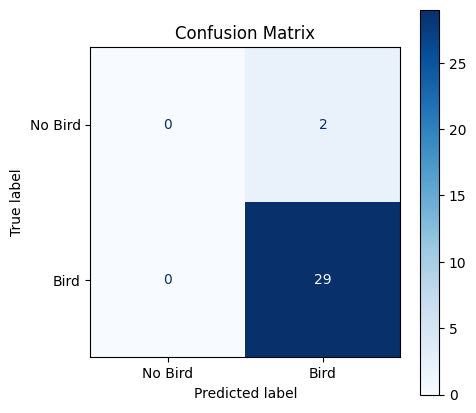

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Bird", "Bird"]
)

# 3. Plot it
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.show()


In [ ]:
sub = {img_id: {"boxes": v["boxes"]} for img_id,v in results.items()}
with open("/content/drive/MyDrive/DL2025/test_predictions.json","w") as f:
    json.dump(sub, f)


In [ ]:
import json, os
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Save submission JSON (only boxes per image)
submission = {
    img_id: {"boxes": v["boxes"]}
    for img_id, v in results.items()
}
out_path = "/content/drive/MyDrive/DL2025/test_predictions.json"
with open(out_path, "w") as f:
    json.dump(submission, f)
print("Submission saved to", out_path)

# [7. COCO-Style mAP Evaluation](https://)

We compute standard COCO mean Average Precision metrics to benchmark our detector across multiple IoU thresholds.

- Build GT JSON (gt_coco.json)

- Convert your test annotations into COCO’s “images” and “annotations” format.

- Each annotation entry has an id, image_id, category_id (1 for bird, bbox, and area.

- Build Detection JSON (pred_coco.json)

- Iterate over your model’s results (filename → boxes & scores).

- For each predicted box, emit a COCO detection entry with image_id, category_id, bbox, and score.

- Run pycocotools Evaluation

- Load GT and DT JSONs into COCO API objects.

- Instantiate COCOeval with iouType="bbox", set params.imgIds to your test set.
- Summarize → prints:

- - AP@[.50:.95] (mAP over all thresholds)

- - AP@.50, AP@.75

- - AP by object size (small, medium, large) and AR metrics

In [ ]:
# Paths
test_ann_path = "/content/drive/MyDrive/DL2025/scarecrow_dataset/scarecrow_dataset/test/annotations.json"
test_img_dir  = "/content/drive/MyDrive/DL2025/scarecrow_dataset/scarecrow_dataset/test/images"

# Load raw test annotations
raw_test = json.load(open(test_ann_path))

# Build COCO GT
coco_gt = {"images": [], "annotations": [], "categories": [{"id":1,"name":"bird"}]}
ann_id = 1
for img_id, item in enumerate(raw_test):
    fn = item["OriginalFileName"]
    w,h = Image.open(os.path.join(test_img_dir,fn)).size
    coco_gt["images"].append({"id":img_id, "file_name":fn, "width":w, "height":h})
    for ann in item.get("AnnotationData",[]):
        xs = [pt["X"] for pt in ann["Coordinates"]]
        ys = [pt["Y"] for pt in ann["Coordinates"]]
        x0,y0 = min(xs), min(ys)
        bw,bh = max(xs)-x0, max(ys)-y0
        coco_gt["annotations"].append({
            "id":ann_id,
            "image_id":img_id,
            "category_id":1,
            "bbox":[x0,y0,bw,bh],
            "area":bw*bh,
            "iscrowd":0
        })
        ann_id += 1

gt_path = "/content/drive/MyDrive/DL2025/gt_coco.json"
with open(gt_path,"w") as f:
    json.dump(coco_gt, f)
print("GT COCO file saved to", gt_path)

# Build COCO DT (predictions)
coco_dt = []
for img_id, item in enumerate(raw_test):
    fn = item["OriginalFileName"]
    pred = results.get(fn, {"boxes":[],"scores":[]})
    for box, score in zip(pred["boxes"], pred.get("scores",[])):
        x0,y0,x1,y1 = box
        coco_dt.append({
            "image_id":img_id,
            "category_id":1,
            "bbox":[x0,y0, x1-x0, y1-y0],
            "score":score
        })

dt_path = "/content/drive/MyDrive/DL2025/pred_coco.json"
with open(dt_path,"w") as f:
    json.dump(coco_dt, f)
print("DT COCO file saved to", dt_path)

In [ ]:
cocoGt = COCO(gt_path)
cocoDt = cocoGt.loadRes(dt_path)
evaluator = COCOeval(cocoGt, cocoDt, iouType="bbox")
evaluator.params.imgIds = cocoGt.getImgIds()
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()

In [ ]:
for fn in list(submission)[:3]:
    img = Image.open(os.path.join(test_img_dir, fn)).convert("RGB")
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    ax = plt.gca()
    for box in submission[fn]["boxes"]:
        x0,y0,x1,y1 = box
        rect = patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(fn)
    plt.axis("off")
    plt.show()

In [ ]:
import os, json, csv
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def save_run(
    run_name: str,
    results: dict,
    metrics: dict,
    hyperparams: dict,
    example_fns: list,
    test_img_dir: str,
    coco_eval_stats: list
):
    out_dir = f"/content/drive/MyDrive/DL2025/results/{run_name}"
    os.makedirs(out_dir, exist_ok=True)

    # 1) Save predictions
    with open(os.path.join(out_dir, "predictions.json"), "w") as f:
        json.dump(results, f)

    # 2) Save COCOeval summary
    with open(os.path.join(out_dir, "coco_eval.txt"), "w") as f:
        f.write("COCOeval stats:\n")
        for name, val in zip([
            "AP@[.5:.95]", "AP@.50", "AP@.75", "AP (small)",
            "AP (medium)", "AP (large)", "AR@1", "AR@10", "AR@100"
        ], coco_eval_stats):
            f.write(f"{name}: {val:.3f}\n")

    # 3) Save metrics + hyperparameters to CSV
    csv_path = os.path.join(out_dir, "metrics.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(hyperparams.keys()) + list(metrics.keys()))
        writer.writeheader()
        writer.writerow({**hyperparams, **metrics})

    # 4) Save example images
    for fn in example_fns:
        img = Image.open(os.path.join(test_img_dir, fn)).convert("RGB")
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(img); ax.axis("off")
        for box in results[fn]["boxes"]:
            x0,y0,x1,y1 = box
            rect = patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                     linewidth=1.5, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        fig.savefig(os.path.join(out_dir, fn), bbox_inches="tight")
        plt.close(fig)

    print(f"Saved run → {out_dir}")


In [ ]:
# Example hyperparameters for this run
hyperparams = {
    "conf_thr": 0.5,
    "resolution": 784,
    "batch_size": 2
}

# Your simple metrics
metrics = {
    "precision": precision,
    "recall": recall,
    "f1": f1
}

# COCOeval.stats from earlier
coco_eval_stats = evaluator.stats.tolist()

# Pick 3 image filenames to visualize
example_fns = [item["OriginalFileName"] for item in raw_test[:3]]

save_run(
    run_name="conf0.5_res784",
    results=results,
    metrics=metrics,
    hyperparams=hyperparams,
    example_fns=example_fns,
    test_img_dir=test_img_dir,
    coco_eval_stats=coco_eval_stats
)


**Results second part**

COCO’s evaluation only counts a detection as a “true positive” if:

- The box overlaps a ground‐truth box of the same category with IoU ≥ threshold (e.g. ≥ 0.5 for AP@.50).

- It’s among the top-maxDets scoring predictions per image.

- Zero across the board tells us that none of your submitted bird boxes met those criteria.

Those numbers are high because:

- If an image contains a bird (ground truth), you almost always predicted at least one box → perfect recall at image‐level.

- When there’s no bird, you rarely predicted any box → high precision.

- But COCO AP/AR is a much stricter test: it cares about each individual bounding box being in the right place, with the right class, and above the IoU cutoff. So it’s entirely possible to “guess a box somewhere” and get credit in the per‐image binary test, yet fail every individual‐box match and score zero in the COCO protocol.

In [ ]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# -------------- 1) Benchmark RF-DETR exports --------------
# (adjust the import if your benchmark lives elsewhere)
from rf_detr.utils import benchmark

results = benchmark(
    model=model_path,
    data="data.yaml",
    imgsz=1024,
    half=False,
    device=0,
)

# results is a list of namedtuples like (format, success, size, metrics, time, fps)

# -------------- 2) Build a DataFrame --------------
df_bench = pd.DataFrame([r._asdict() for r in results])

# rename to match your screenshot
df_bench = df_bench.rename(columns={
    "format":  "Format",
    "success": "✔/✘",
    "size":    "Size (MB)",
    "metrics": "mAP50–95",
    "time":    "ms/im",
    "fps":     "FPS",
})

# if metrics is a tuple, pick the right element (e.g. AP@[.50:.95])
if df_bench["mAP50–95"].dtype == object:
    df_bench["mAP50–95"] = df_bench["mAP50–95"].apply(lambda x: x if isinstance(x, float) else x[1])

# -------------- 3) Classification metrics --------------
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("=== Classification Performance ===")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}\n")

print("--- Per-class Report ---")
print(classification_report(
    y_true, y_pred,
    target_names=["No Bird", "Bird"],
    digits=3
))

# -------------- 5) Print your RF-DETR benchmark table --------------
print("=== RF-DETR Export Benchmarks ===")
print(tabulate(df_bench, headers="keys", tablefmt="github", showindex=False))


ModuleNotFoundError: No module named 'rf_detr'

Measuring the inference speed of the trained RF-DETR model by running it on the test dataset and calculating the average frames per second (FPS), to evaluate the model’s suitability for real-time or near real-time deployment on GPU hardware.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Load model
model = RFDETRBase(
    encoder="dinov2_windowed_small",
    num_classes=1,
    pretrain_weights=None,
    resolution=784,
    device=device.type,
    drop_path_rate=0.12150897038028768,
    num_queries=200,
    multi_scale=False
)

model_path = "/content/drive/MyDrive/Colab Notebooks/rf_detr_best.pth"
model.model.model.load_state_dict(torch.load(model_path))
model.model.model = model.model.model.to(device)
model.model.model.eval()


# Inference transform
infer_transform = A.Compose([
    A.Resize(784, 784),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

# Dataset + Dataloader
test_dataset = CustomDataset(
    label_path=test_label_path,
    im_path=test_img_dir,
    transforms=infer_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Benchmark
num_images = 0
start_time = time.time()

with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Benchmarking FPS"):
        images = images.to(device)
        outputs = model.model.model(images)
        num_images += images.size(0)

end_time = time.time()
total_time = end_time - start_time
fps = num_images / total_time

print(f"\n Inference completed: {num_images} images in {total_time:.2f} seconds")
print(f" Average FPS: {fps:.2f}")
